# Visualizations: model training and analysis
This notebook produces 15+ visualizations for the Fake-News-Detector project:
- Training / validation curves
- Confusion matrices (baseline vs LSTM)
- ROC and Precision-Recall curves
- t-SNE visualization of learned embeddings
- N-gram frequency comparisons and baseline feature importances
- Word clouds and sample misclassifications
Figures are saved to `reports/figures/` so they can be referenced in the README or reports.

In [1]:
# imports and helper utilities
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Directories
ARTIFACTS = Path('..') / 'artifacts' if (Path('..') / 'artifacts').exists() else Path('artifacts')
REPORTS = Path('..') / 'reports' if (Path('..') / 'reports').exists() else Path('reports')
FIG_DIR = REPORTS / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

sns.set(style='whitegrid')

In [13]:
# Make repository importable from this notebook
import sys
from pathlib import Path
repo_root = (Path('.') / '..').resolve()  # notebook lives in notebooks/
sys.path.insert(0, str(repo_root))
print('Inserted repo root into sys.path:', sys.path[0])

Inserted repo root into sys.path: /Users/venudave/Desktop/projectgit/News-Interpreter


In [12]:
# load artifacts and raw data (texts + labels)
from scripts import train_lstm
import pickle

texts, labels = train_lstm.load_data(min_samples=10000)
print('Loaded', len(texts), 'texts')

# load baseline model bundle if available
baseline_bundle = None
baseline_path = ARTIFACTS / 'baseline.pkl'
if baseline_path.exists():
    with open(baseline_path, 'rb') as f:
        baseline_bundle = pickle.load(f)
        print('Loaded baseline bundle (vectorizer+classifier) from', baseline_path)
else:
    print('Baseline artifact not found at', baseline_path)

# load LSTM model if present
lstm_model = None
try:
    from tensorflow.keras.models import load_model
    lstm_path = ARTIFACTS / 'lstm.h5'
    if lstm_path.exists():
        lstm_model = load_model(str(lstm_path))
        print('Loaded LSTM model from', lstm_path)
    else:
        print('LSTM artifact not found at', lstm_path)
except Exception as e:
    print('Unable to load LSTM model:', e)

Loaded 10000 texts
Loaded baseline bundle (vectorizer+classifier) from ../artifacts/baseline.pkl
Loaded LSTM model from ../artifacts/lstm.h5


In [14]:
# prepare tokenizer / splits for evaluation
from tensorflow.keras.preprocessing.text import tokenizer_from_json, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_texts, X_test_texts, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)
print('Train/Test counts:', len(X_train_texts), len(X_test_texts))

tokenizer = None
tok_path = ARTIFACTS / 'tokenizer.json'
if tok_path.exists():
    with open(tok_path, 'r', encoding='utf-8') as f:
        tokenizer = tokenizer_from_json(f.read())
    print('Loaded tokenizer from', tok_path)
else:
    tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train_texts)
    print('Fitted new tokenizer on training texts')

seqs_test = tokenizer.texts_to_sequences(X_test_texts)
maxlen = 500
X_test_seq = pad_sequences(seqs_test, maxlen=maxlen)

def baseline_predict_proba(texts):
    if baseline_bundle is None:
        raise RuntimeError('Baseline model not available')
    vect = baseline_bundle['vectorizer']
    clf = baseline_bundle['classifier']
    Xv = vect.transform(texts)
    if hasattr(clf, 'predict_proba'):
        return clf.predict_proba(Xv)[:,1]
    else:
        scores = clf.decision_function(Xv)
        smin, smax = scores.min(), scores.max()
        return (scores - smin) / (smax - smin + 1e-12)

def lstm_predict_proba(texts):
    if lstm_model is None:
        raise RuntimeError('LSTM model not available')
    seqs = tokenizer.texts_to_sequences(texts)
    Xp = pad_sequences(seqs, maxlen=maxlen)
    return lstm_model.predict(Xp).ravel()

Train/Test counts: 8000 2000
Loaded tokenizer from ../artifacts/tokenizer.json


## Training and validation curves
Plot loss/accuracy curves from the LSTM training history saved in `reports/lstm_history.json`.

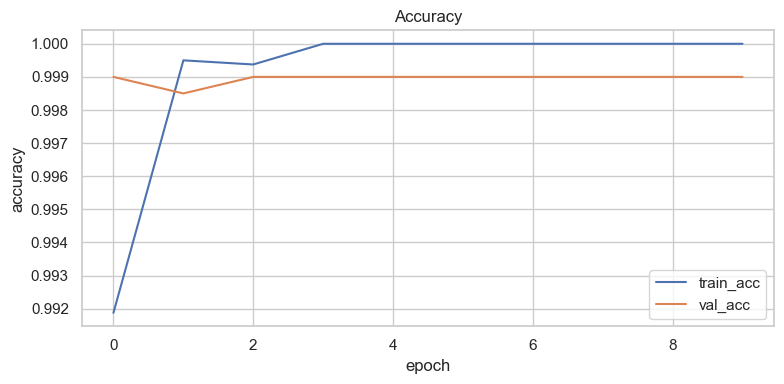

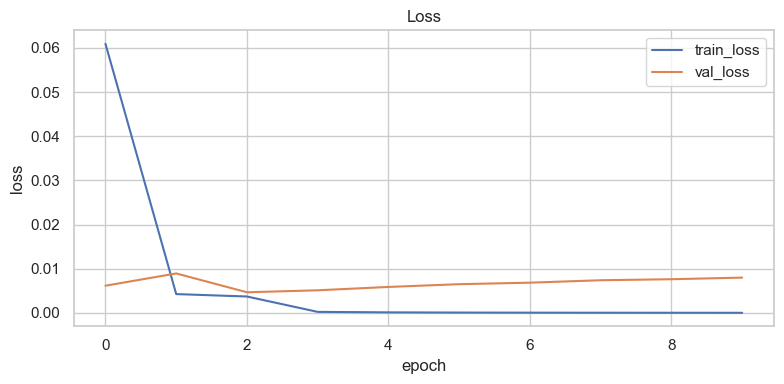

In [15]:
hist_path = REPORTS / 'lstm_history.json'
if hist_path.exists():
    with open(hist_path, 'r', encoding='utf-8') as f:
        history = json.load(f)
    plt.figure(figsize=(8,4))
    plt.plot(history.get('accuracy', []), label='train_acc')
    plt.plot(history.get('val_accuracy', []), label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'accuracy_curve.png')
    plt.show()
    plt.figure(figsize=(8,4))
    plt.plot(history.get('loss', []), label='train_loss')
    plt.plot(history.get('val_loss', []), label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'loss_curve.png')
    plt.show()
else:
    print('No history found at', hist_path)

## Confusion matrices (baseline vs LSTM)
Compare predicted labels on the same test set.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


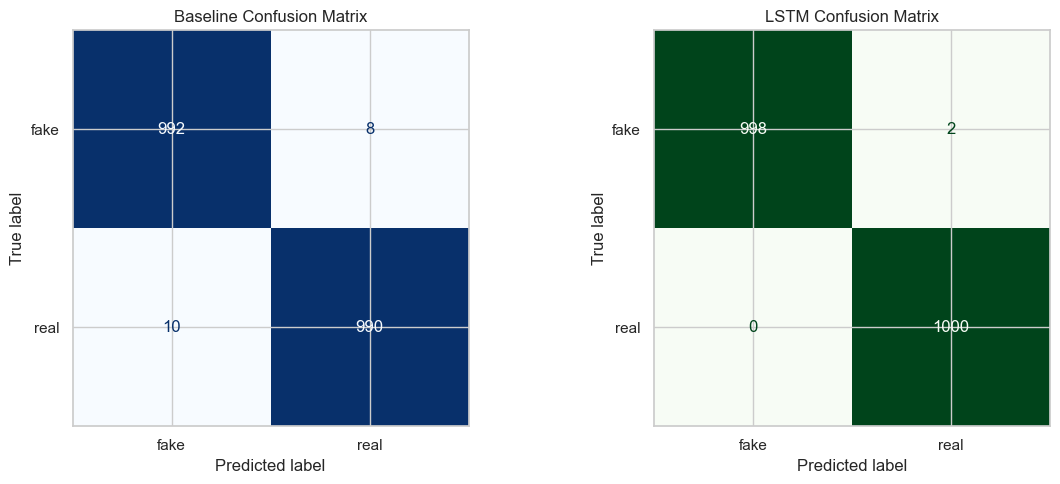

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

if baseline_bundle is not None and lstm_model is not None:
    base_probs = baseline_predict_proba(X_test_texts)
    base_preds = (base_probs >= 0.5).astype(int)
    lstm_probs = lstm_predict_proba(X_test_texts)
    lstm_preds = (lstm_probs >= 0.5).astype(int)

    fig, axes = plt.subplots(1,2, figsize=(12,5))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, base_preds), display_labels=['fake','real'])
    disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
    axes[0].set_title('Baseline Confusion Matrix')
    disp2 = ConfusionMatrixDisplay(confusion_matrix(y_test, lstm_preds), display_labels=['fake','real'])
    disp2.plot(ax=axes[1], cmap='Greens', colorbar=False)
    axes[1].set_title('LSTM Confusion Matrix')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'confusion_matrices.png')
    plt.show()
else:
    print('Baseline or LSTM model missing; cannot produce confusion matrices')

## ROC and Precision-Recall curves
Plot ROC and PR curves for both models to compare discriminative performance.

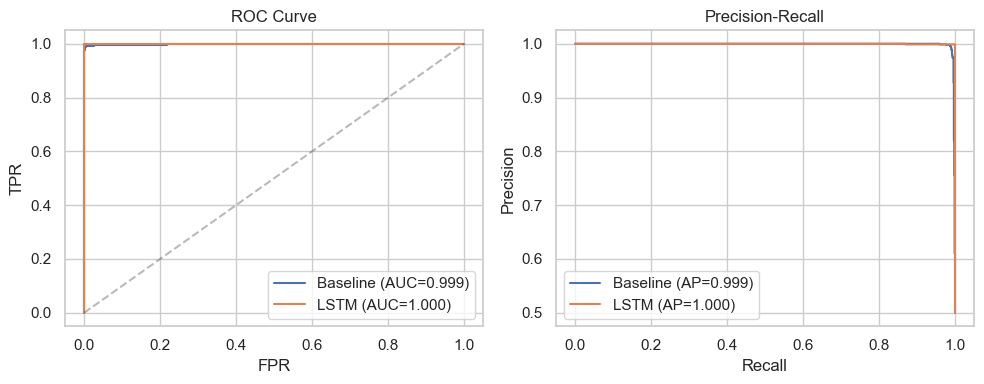

In [17]:
plt.figure(figsize=(10,4))
if baseline_bundle is not None and lstm_model is not None:
    fpr_b, tpr_b, _ = roc_curve(y_test, base_probs)
    roc_auc_b = auc(fpr_b, tpr_b)
    fpr_l, tpr_l, _ = roc_curve(y_test, lstm_probs)
    roc_auc_l = auc(fpr_l, tpr_l)
    plt.subplot(1,2,1)
    plt.plot(fpr_b, tpr_b, label=f'Baseline (AUC={roc_auc_b:.3f})')
    plt.plot(fpr_l, tpr_l, label=f'LSTM (AUC={roc_auc_l:.3f})')
    plt.plot([0,1],[0,1],'k--', alpha=0.3)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()
    plt.subplot(1,2,2)
    prec_b, rec_b, _ = precision_recall_curve(y_test, base_probs)
    ap_b = average_precision_score(y_test, base_probs)
    prec_l, rec_l, _ = precision_recall_curve(y_test, lstm_probs)
    ap_l = average_precision_score(y_test, lstm_probs)
    plt.plot(rec_b, prec_b, label=f'Baseline (AP={ap_b:.3f})')
    plt.plot(rec_l, prec_l, label=f'LSTM (AP={ap_l:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall')
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'roc_pr_curves.png')
    plt.show()
else:
    print('Models missing; cannot compute ROC/PR curves')

## t-SNE visualization of learned embeddings
Project a subset of the embedding vectors into 2D with t-SNE to inspect semantic clusters.

Embeddings shape: (10000, 128)


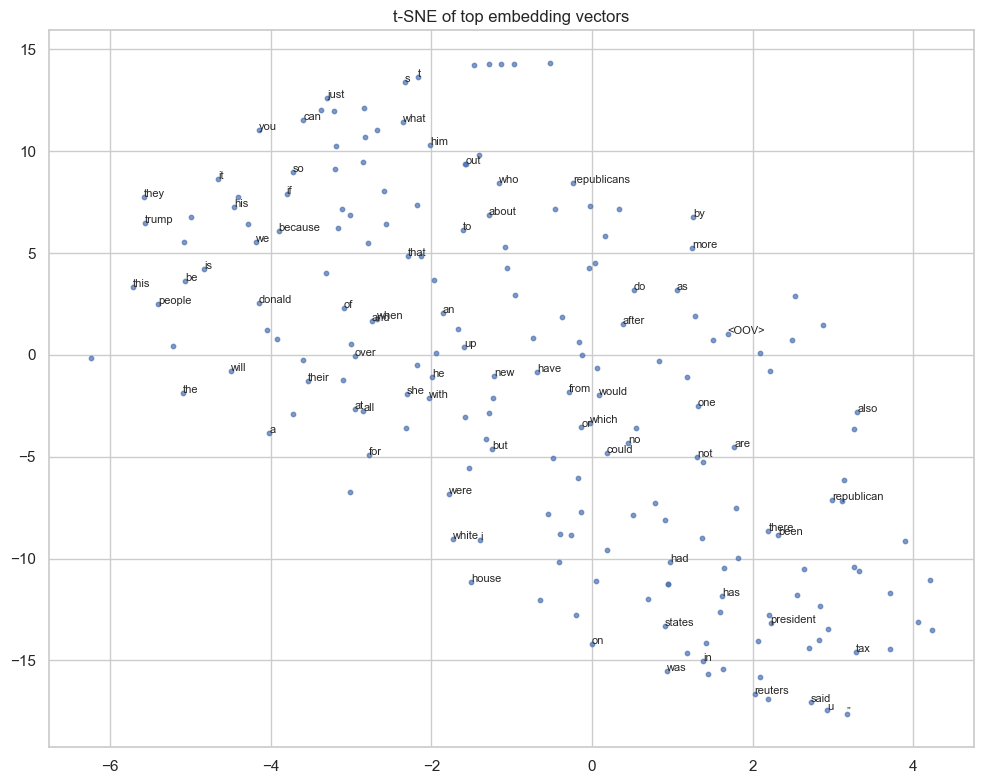

In [18]:
if lstm_model is not None:
    try:
        emb_layer = lstm_model.layers[0]  # Embedding layer
        embeddings = emb_layer.get_weights()[0]  # shape (vocab_size, embed_dim)
        print('Embeddings shape:', embeddings.shape)
        word_index = getattr(tokenizer, 'word_index', None)
        if word_index is None:
            print('Tokenizer has no word_index; skipping embedding viz')
        else:
            inv = {v:k for k,v in word_index.items()}
            N = 200
            indices = [i for i in range(1, min(len(embeddings), N))]
            subset = embeddings[indices]
            pca = PCA(n_components=30)
            reduced = pca.fit_transform(subset)
            tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
            coords = tsne.fit_transform(reduced)
            plt.figure(figsize=(10,8))
            plt.scatter(coords[:,0], coords[:,1], s=10, alpha=0.7)
            for i, idx in enumerate(indices[:80]):
                w = inv.get(idx, '')
                plt.text(coords[i,0], coords[i,1], w, fontsize=8)
            plt.title('t-SNE of top embedding vectors')
            plt.tight_layout()
            plt.savefig(FIG_DIR / 'embedding_tsne.png')
            plt.show()
    except Exception as e:
        print('Failed to visualize embeddings:', e)
else:
    print('LSTM model not available; skipping embedding t-SNE')

## N-gram frequency comparisons and baseline feature importances
Show the most frequent unigrams/bigrams per class and the top coefficients from the baseline logistic regression.

CountVectorizer vocab size: 20000


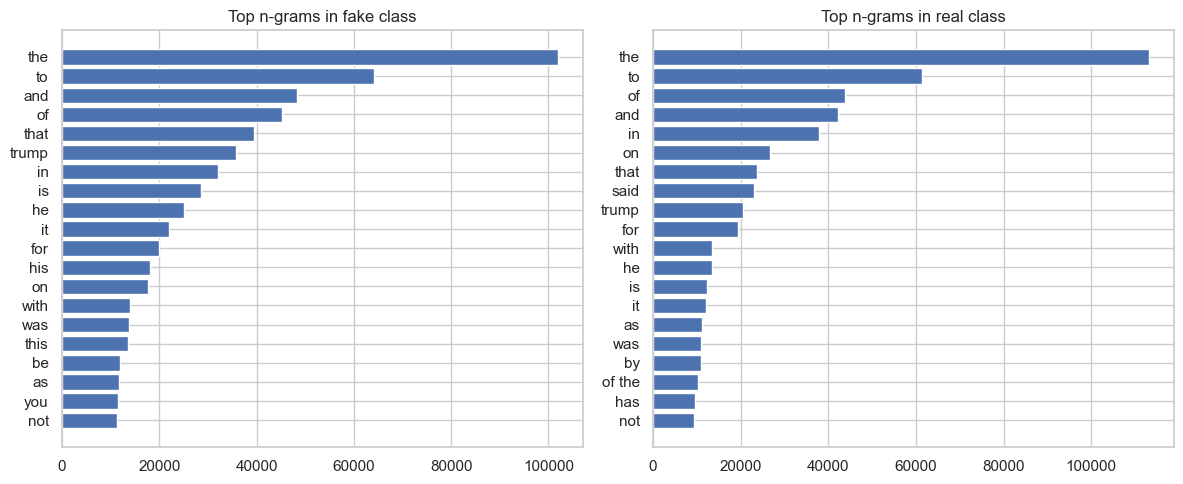

Baseline model not available; skipping feature importances


In [11]:
cv = CountVectorizer(ngram_range=(1,2), max_features=20000)
X_counts = cv.fit_transform(texts)
vocab = cv.get_feature_names_out()
print('CountVectorizer vocab size:', len(vocab))
fake_mask = np.array(labels) == 0
real_mask = np.array(labels) == 1
fake_counts = np.asarray(X_counts[fake_mask].sum(axis=0)).ravel()
real_counts = np.asarray(X_counts[real_mask].sum(axis=0)).ravel()
topk = 20
fake_top_idx = np.argsort(-fake_counts)[:topk]
real_top_idx = np.argsort(-real_counts)[:topk]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.barh([vocab[i] for i in fake_top_idx[::-1]], fake_counts[fake_top_idx][::-1])
plt.title('Top n-grams in fake class')
plt.subplot(1,2,2)
plt.barh([vocab[i] for i in real_top_idx[::-1]], real_counts[real_top_idx][::-1])
plt.title('Top n-grams in real class')
plt.tight_layout()
plt.savefig(FIG_DIR / 'top_ngrams_per_class.png')
plt.show()

if baseline_bundle is not None:
    clf = baseline_bundle['classifier']
    vect = baseline_bundle['vectorizer']
    try:
        feat_names = vect.get_feature_names_out()
        coefs = clf.coef_.ravel()
        top_pos = np.argsort(-coefs)[:20]
        top_neg = np.argsort(coefs)[:20]
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.barh(feat_names[top_pos[::-1]], coefs[top_pos][::-1])
        plt.title('Top positive coefficients (predict real)')
        plt.subplot(1,2,2)
        plt.barh(feat_names[top_neg[::-1]], coefs[top_neg][::-1])
        plt.title('Top negative coefficients (predict fake)')
        plt.tight_layout()
        plt.savefig(FIG_DIR / 'baseline_top_coeffs.png')
        plt.show()
    except Exception as e:
        print('Baseline feature importance plot failed:', e)
else:
    print('Baseline model not available; skipping feature importances')

## Word clouds and sample misclassifications
Generate simple word clouds for each class and print a few misclassified examples by each model.

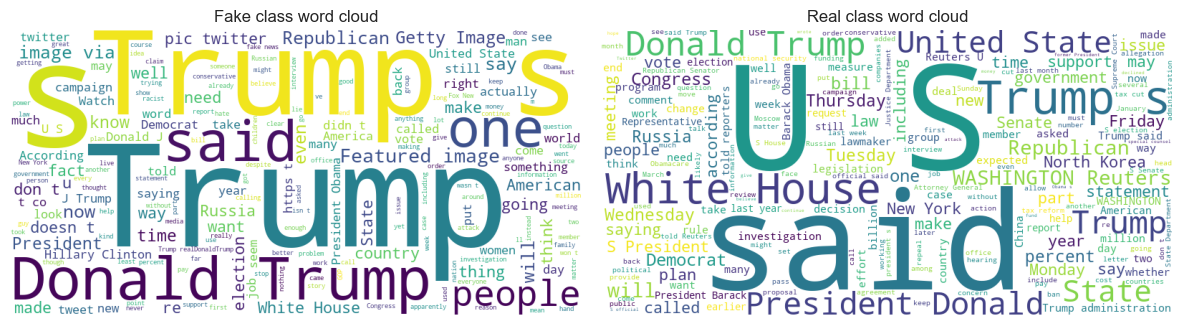

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
---
Index 216 | True=0 | Baseline=1 | LSTM=0
After Hurricane Harvey devastated Houston, Texas, then Irma barreled through the Caribbean on its way to Florida, two Senate Florida Senators are warning that the U.S. Federal Emergency Management Agency (FEMA) will run out of disaster assistance funding on Friday unless Congress approves more money.Republicans in the House had been looking at cutting almost $1 billion from disaster accounts to help finance Donald Trump s ego-wall on the Southern Border and now that a natural disaster occurred w

---
Index 259 | True=1 | Baseline=0 | LSTM=1
WASHINGTON (Reuters) - Here are highlights of the Reuters Oval Office interview with U.S. President Donald Trump on Wednesday. ON WHETHER HE WAS AWARE HIS SON DONALD TRUMP JR. WAS MEETING WITH A RUSSIAN LAWYER “No. That I didn’t know. Until a couple of days ago, when I heard about this. No I didn’t know about that.” ON WHETHER

In [19]:
try:
    from wordcloud import WordCloud
    have_wordcloud = True
except Exception:
    have_wordcloud = False

fake_text = ' '.join([t for t,l in zip(texts, labels) if l==0])
real_text = ' '.join([t for t,l in zip(texts, labels) if l==1])

if have_wordcloud:
    wc = WordCloud(width=800, height=400, background_color='white')
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(wc.generate(fake_text))
    plt.axis('off')
    plt.title('Fake class word cloud')
    plt.subplot(1,2,2)
    plt.imshow(wc.generate(real_text))
    plt.axis('off')
    plt.title('Real class word cloud')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'wordclouds.png')
    plt.show()
else:
    print('wordcloud not installed; skipping wordcloud plots (pip install wordcloud)')

def show_misclassified(limit=6):
    examples = []
    if baseline_bundle is not None and lstm_model is not None:
        base_preds = (baseline_predict_proba(X_test_texts) >= 0.5).astype(int)
        lstm_preds = (lstm_predict_proba(X_test_texts) >= 0.5).astype(int)
        for i, (txt, y_true) in enumerate(zip(X_test_texts, y_test)):
            if base_preds[i] != y_true or lstm_preds[i] != y_true:
                examples.append((i, txt, y_true, int(base_preds[i]), int(lstm_preds[i])))
    for e in examples[:limit]:
        idx, txt, true, bpred, lpred = e
        print('---')
        print(f'Index {idx} | True={true} | Baseline={bpred} | LSTM={lpred}')
        print(txt[:500])
        print()

show_misclassified(10)